In [1]:
import torch
import torch.nn as nn

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.3,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

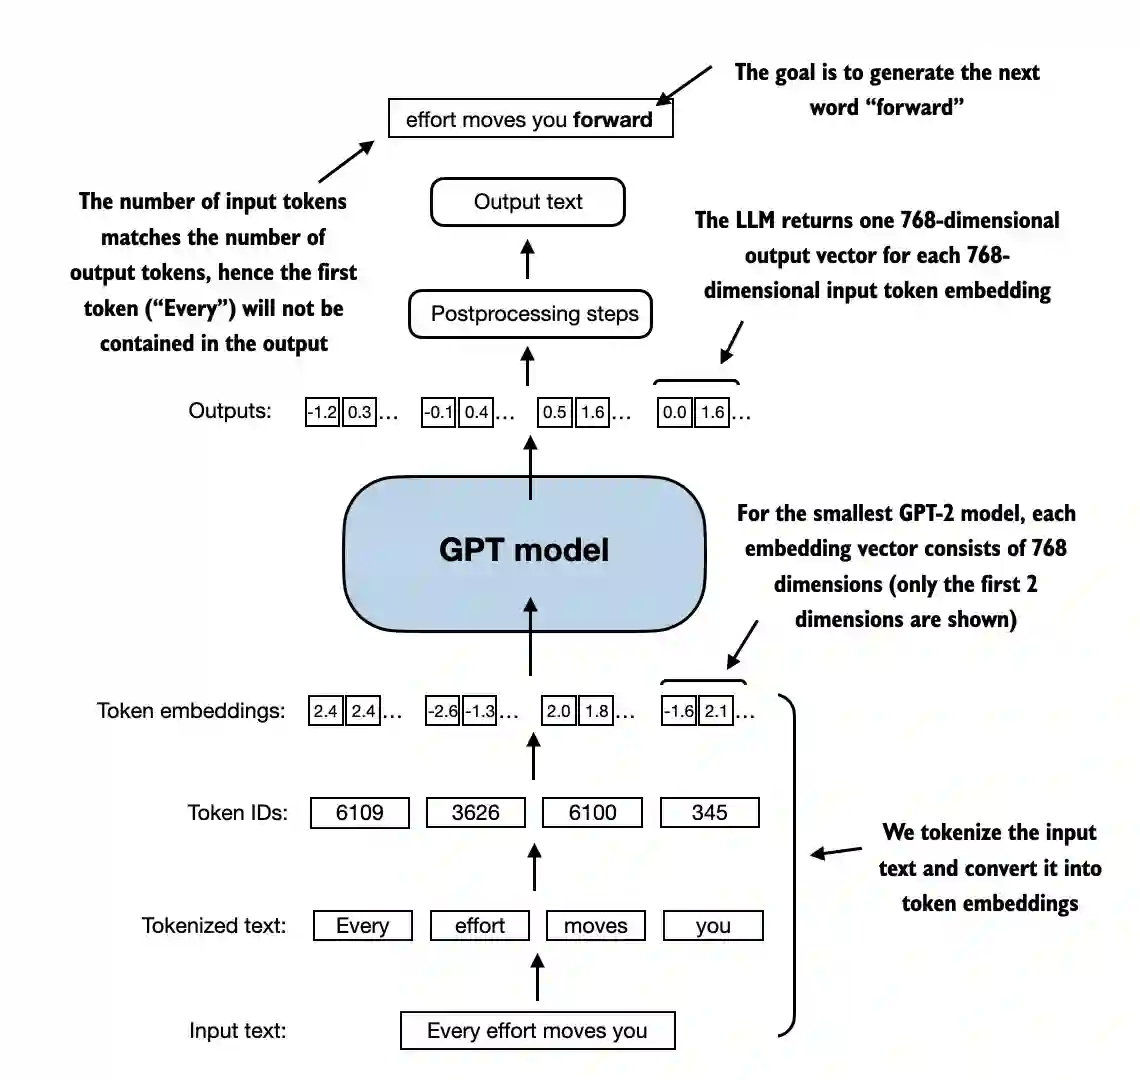

In [39]:
# Configuration dictionary for the embedding layer
cfg = {
    "vocab_size": 100,  # Size of the vocabulary (number of tokens)
    "emb_dim": 16       # Dimension of the embedding space
}

# Define the embedding layer
tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])

# Example input: token indices (let's simulate a sequence of token IDs)
token_indices = torch.tensor([1, 5, 23, 45, 10])  # Token indices from the vocabulary

# Get embeddings for these tokens
embeddings = tok_emb(token_indices)

print("Token indices:", token_indices)
print("Embeddings shape:", embeddings.shape)
print("Embeddings:\n", embeddings)

Token indices: tensor([ 1,  5, 23, 45, 10])
Embeddings shape: torch.Size([5, 16])
Embeddings:
 tensor([[-0.8188,  0.6520,  0.5493,  1.8132,  2.0640, -1.3814,  1.8216, -0.0111,
          1.7362, -0.5770,  0.3257, -0.1176, -0.9884, -2.0339, -0.6053, -0.0654],
        [-0.0942,  0.3834,  0.0249, -0.0251, -0.9500,  2.1791, -2.2755,  0.5606,
         -0.4856,  0.9983, -0.0356, -1.1198, -1.8398, -0.4091, -1.1214,  0.6446],
        [ 0.9196,  0.4702, -0.1653, -1.4885,  0.3121, -0.9718,  0.9486, -0.0362,
          0.9131, -0.2579,  0.7399, -0.5417,  0.7841,  0.4128,  0.2883,  1.1673],
        [ 1.1803,  0.6059, -0.9306,  0.4733, -1.0293, -0.3374, -0.3665, -0.9046,
          0.8705, -0.8962,  1.1091, -0.7527,  0.0441,  0.6474, -0.6920,  1.4360],
        [-1.3230, -0.4731,  2.0857,  0.4183,  0.3593,  1.6287,  1.0343,  0.6124,
         -0.5758,  1.5484,  0.5610,  1.1305, -1.8065,  2.2770, -0.8933, -0.4592]],
       grad_fn=<EmbeddingBackward0>)


In [31]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb= nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size , seq_len = in_idx.shape
        #Calculating token and postitional embeddings
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device= in_idx.device))
        # Transforming to context vector
        x = tok_embeds + pos_embeds
        # Dropout
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape , eps = 1e-5):
        super().__init__()

    def forward(self,x):
        return x

In [32]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []

txt1 = "where did all the time"
txt2 = "where were you last day"

In [33]:
enc_txt1 = tokenizer.encode(txt1)
enc_txt2 = tokenizer.encode(txt2)
print(len(enc_txt1))
print(len(enc_txt2))

5
5


In [34]:
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim = 0)

In [35]:
batch

tensor([[3003,  750,  477,  262,  640],
        [3003,  547,  345,  938, 1110]])

In [36]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

In [37]:
logits = model(batch)
print("Output shape", logits.shape)
print(logits)

Output shape torch.Size([2, 5, 50257])
tensor([[[-0.1375,  0.2704, -0.6588,  ..., -1.6047,  1.4894,  1.0704],
         [-0.6395, -0.1799, -1.6952,  ..., -0.2163, -0.9595,  2.1639],
         [ 0.1593,  1.5806,  0.0583,  ...,  0.9738,  0.9553, -0.3853],
         [-0.4216,  0.1341, -0.0398,  ...,  1.6539, -0.1443,  0.8532],
         [ 1.1552, -0.3458,  2.1542,  ...,  1.0876, -0.4830,  0.7079]],

        [[ 1.0305,  0.6806, -1.1939,  ..., -2.3724,  0.3153,  0.0496],
         [ 0.9952,  1.2341, -0.8646,  ...,  1.4160, -0.1588,  0.9817],
         [ 0.0051,  1.5230,  0.5419,  ..., -0.7091,  0.5170, -0.7145],
         [ 0.8349,  2.3377,  0.1880,  ...,  2.1627,  0.9877,  1.4435],
         [-0.7326, -0.0927,  0.1751,  ...,  0.6539, -1.1913, -0.6935]]],
       grad_fn=<UnsafeViewBackward0>)


## Layer Normalization
- Making the mean =  0 and the variance = 1.
- Zero centered mean dna unit variance.
- Why is this done?
    - To speed up convergence. Reduce exploding and vanishing gradients.

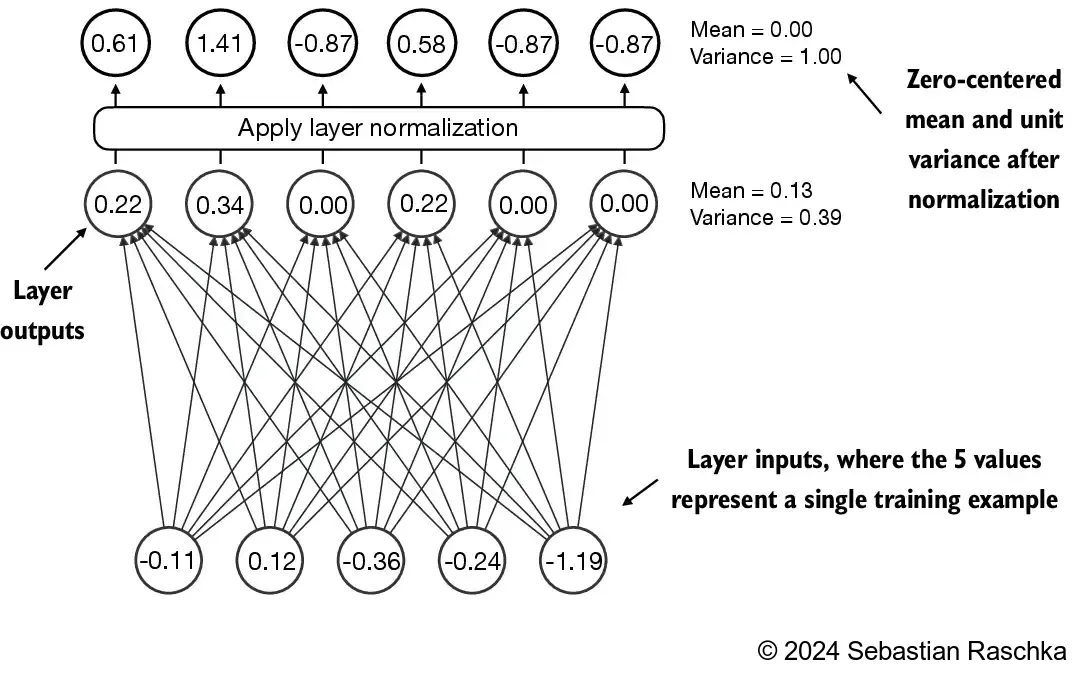

In [40]:
batch_example = torch.randn(2,5)
batch_example

tensor([[ 1.7013, -0.5338, -0.5794, -0.0339, -0.3029],
        [-0.0656,  1.2272, -0.2864, -0.9517,  0.0461]])

In [56]:
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
layer

Sequential(
  (0): Linear(in_features=5, out_features=6, bias=True)
  (1): ReLU()
)

In [57]:
out= layer(batch_example)
out

tensor([[0.0000, 0.0000, 0.0779, 0.3190, 0.0000, 0.3731],
        [0.0000, 0.6844, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)

In [58]:
mean = out.mean(dim =-1, keepdim = True)
var = out.var(dim = -1, keepdim = True)
print('mean', mean)
print('var', var)

mean tensor([[0.1283],
        [0.1141]], grad_fn=<MeanBackward1>)
var tensor([[0.0296],
        [0.0781]], grad_fn=<VarBackward0>)


Layer Norm 
- Subtracting the mean and dividing by the square-root of the variance (standard deviation) centers the inputs to have a mean of 0 and a variance of 1 across the column (feature) dimension:

In [50]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[-0.4082, -0.4082,  2.0412, -0.4082, -0.4082, -0.4082],
        [-0.4317, -0.4317, -0.4317, -0.3123,  2.0389, -0.4317]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[4.9671e-09],
        [4.9671e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [51]:
# Thus, the mean = 0 and the var = 1
mean_norm.sum()

tensor(5.4638e-08, grad_fn=<SumBackward0>)

In [52]:
var_norm

tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)

### Layer Norm Class
Scale and Shift used to prevent division by 0

In [59]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim = -1, keepdim = True)
        var = x.var(dim = -1, keepdim = True)
        norm_x = (x-mean)/torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [60]:
batch_example

tensor([[ 1.7013, -0.5338, -0.5794, -0.0339, -0.3029],
        [-0.0656,  1.2272, -0.2864, -0.9517,  0.0461]])

In [61]:
ln = LayerNorm(emb_dim = 5)
out_ln= ln(batch_example)
print(out_ln)

tensor([[ 1.7415, -0.6161, -0.6641, -0.0888, -0.3725],
        [-0.0753,  1.5600, -0.3546, -1.1961,  0.0660]], grad_fn=<AddBackward0>)


In [62]:
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, keepdim = True)

In [63]:
sum(mean)

tensor([-8.9407e-09], grad_fn=<AddBackward0>)

In [64]:
var

tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)

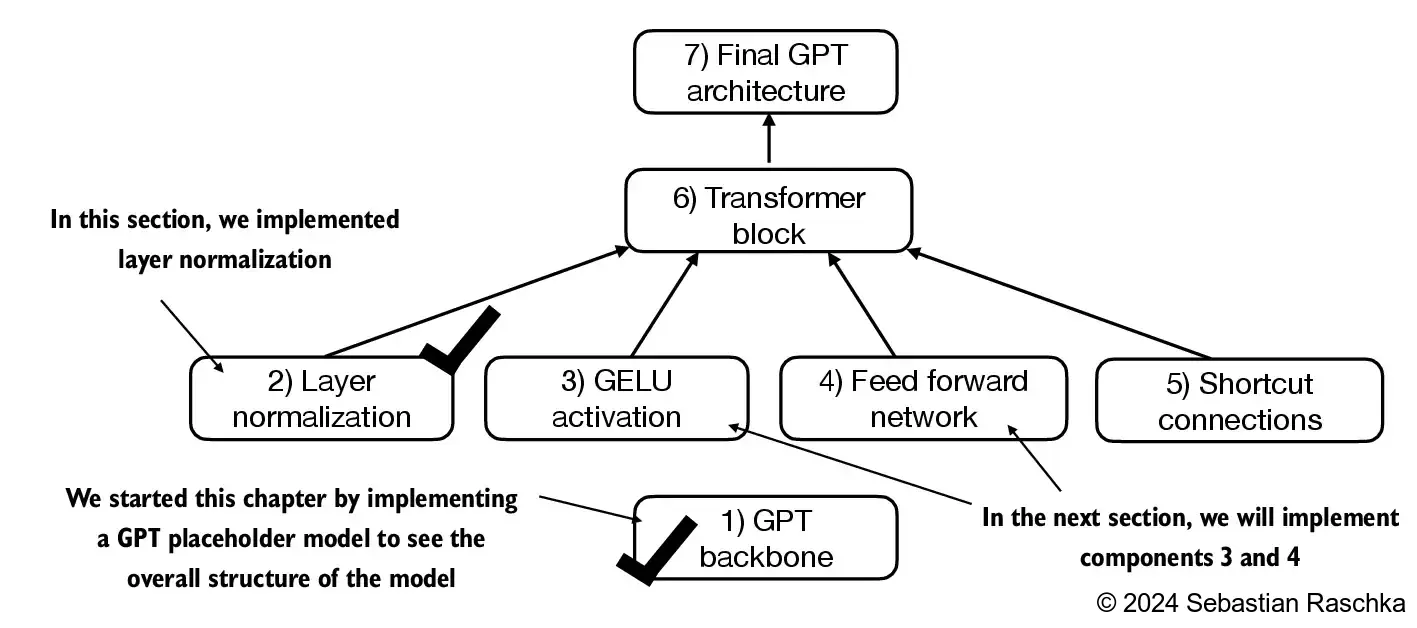

### GELU Activation Class

In [66]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi)) * 
                                         (x + 0.044715 * torch.pow(x,3))))

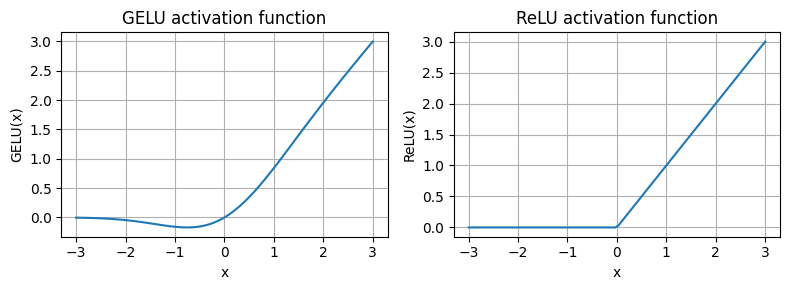

In [67]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [68]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'],cfg['emb_dim']),
        )
    def forward(self, x):
        return self.layers(x)

In [69]:
print(GPT_CONFIG_124M["emb_dim"])

768


In [70]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.randn(2,3,768)
out = ffn(x)
out.shape

torch.Size([2, 3, 768])

### Adding Shortcut connections
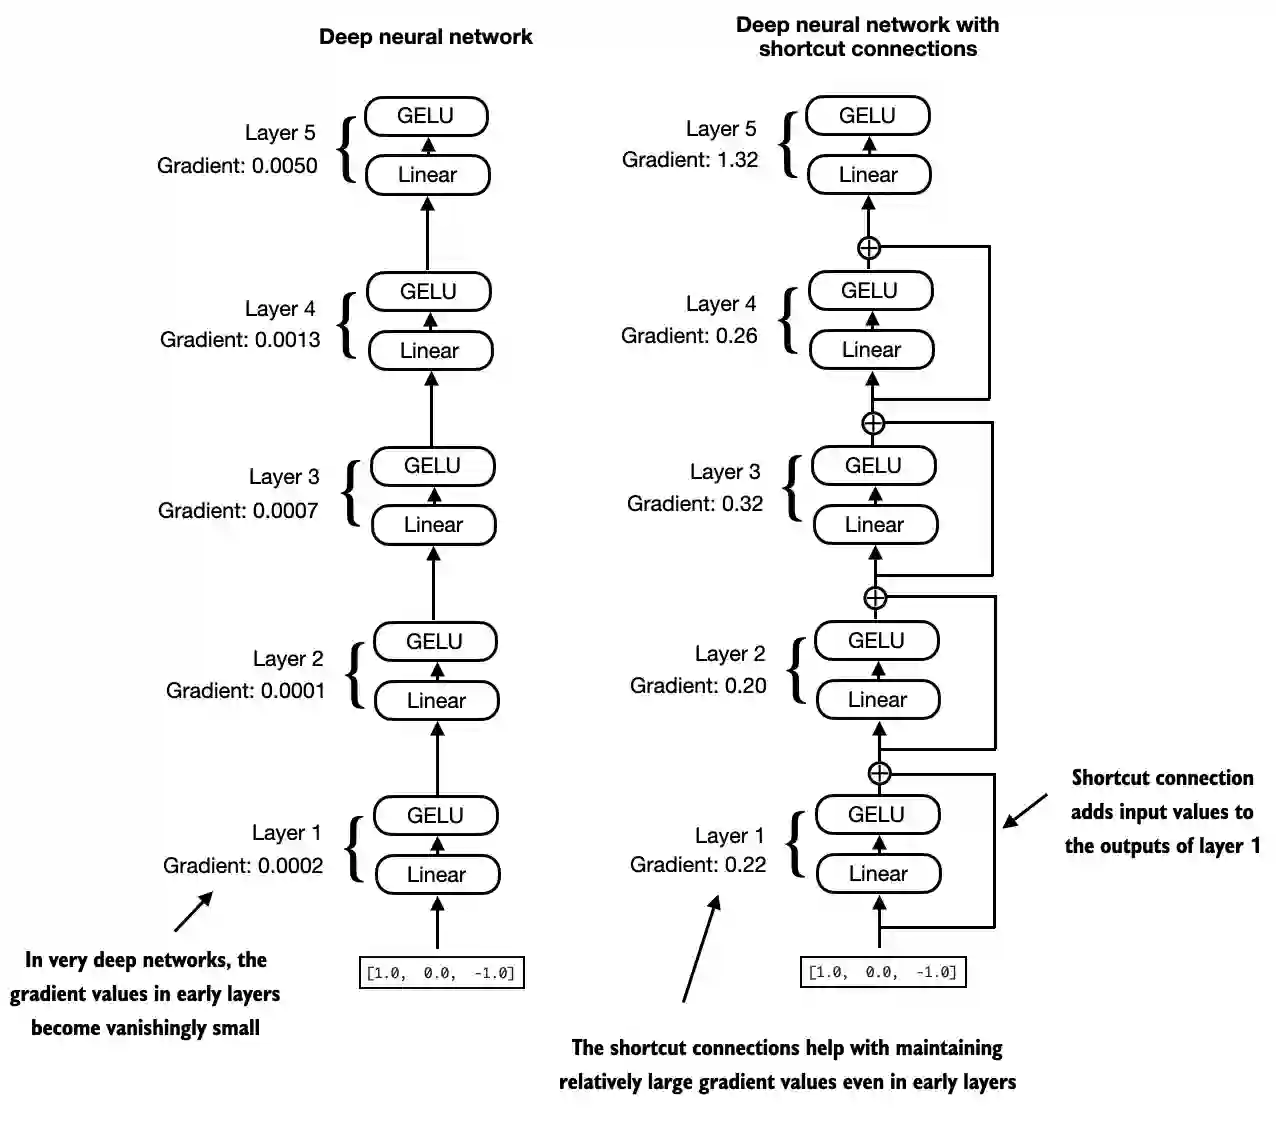

In [71]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [72]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate Loss
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward Pass to cal gradients
    loss.backward()
    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [73]:
layer_sizes = [3,3,3,3,3,1]
sample_input= torch.tensor([[1.0,0.0,-1.0]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut = False)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152039906941354
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


In [74]:
# With shortcut, the gradients are bigger than the ones where we dont use Shortcut
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut = True)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00040347175672650337
layers.1.0.weight has gradient mean of 0.00024022319121286273
layers.2.0.weight has gradient mean of 0.0014304079813882709
layers.3.0.weight has gradient mean of 0.002797747263684869
layers.4.0.weight has gradient mean of 0.010099290870130062


## Connecting Attention and Linear Layers in a Transformer Block
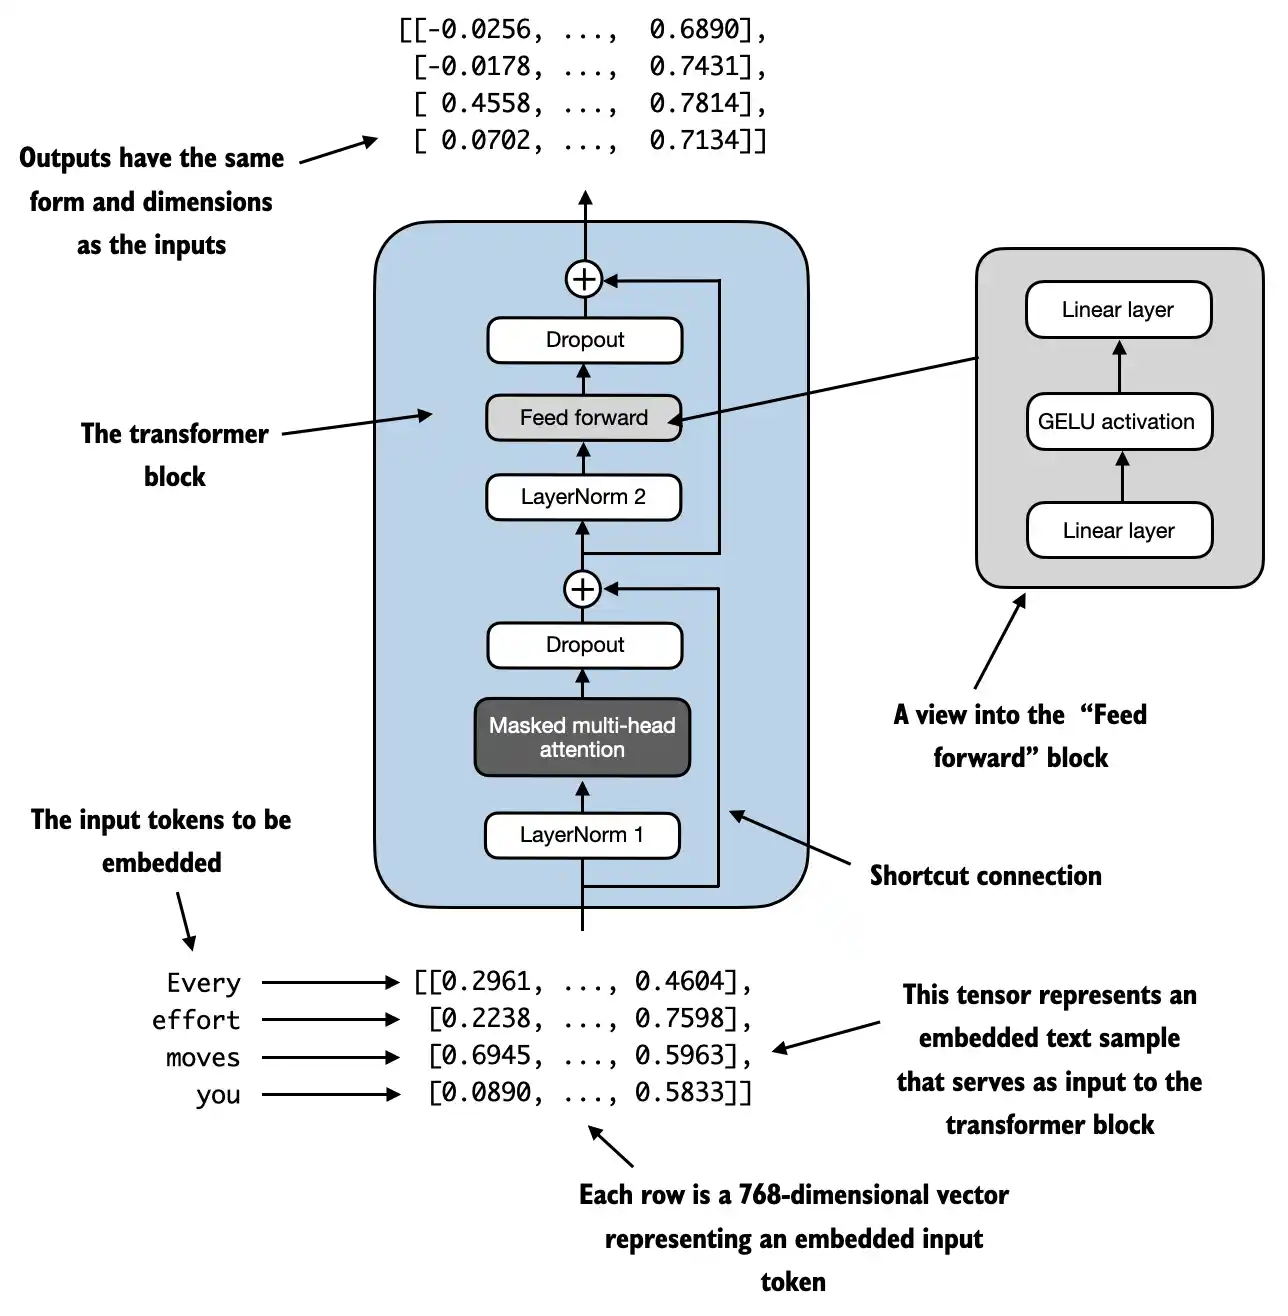

In [75]:
from previous_chapters import MultiHeadAttention

In [76]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
    Image(
      url="https://mermaid.ink/img/"
      + base64_string
    )
  )

mm("""
graph TD
    A[Input x: shape b x num_tokens x d_in] --> B[Linear Transformations]
    B --> C[W_query]
    B --> D[W_key]
    B --> E[W_value]
    C --> F[Reshape and Transpose]
    D --> F
    E --> F
    F --> G[Compute Attention Scores]
    G --> H[Apply Mask]
    H --> I[Softmax and Dropout]
    I --> J[Compute Context Vectors]
    J --> K[Combine Heads]
    K --> L[Output Projection]
    L --> M[Output: shape b x num_tokens x d_out]
""")

GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.3,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [79]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in = cfg['emb_dim'],
            d_out = cfg['emb_dim'],
            context_length = cfg['context_length'],
            dropout = cfg['drop_rate'],
            num_heads= cfg['n_heads'],
            qkv_bias = cfg['qkv_bias'],
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg['emb_dim'])
        self.norm2 = LayerNorm(cfg['emb_dim'])
        self.drop_shortcut = nn.Dropout(cfg['drop_rate'])

    def forward(self, x):
        # shortcut connection for attention block
        shortcut = x
        # Doing layer norm
        x = self.norm1(x)
        # Going to the attention
        x = self.att(x) # Shape [batch_size, num_tokens, emb_size]
        x= self.drop_shortcut(x)
        x = x+ shortcut # Add the layer back

        # Shortcut connections for FeedForward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        return x       

INPUT (x) ───────────────┐
                         │
                 +-------v-------+
    Norm1  --->  MultiHeadAttention
                 +-------v-------+
    Dropout ---> Residual (Add Shortcut)
                         │
INPUT (x) ───────────────┐
                         │
                 +-------v-------+
    Norm2  --->  FeedForward
                 +-------v-------+
    Dropout ---> Residual (Add Shortcut)
                         │
                     OUTPUT

In [83]:
torch.manual_seed(123)
x = torch.randn(2,4,768)
x

tensor([[[ 0.3374, -0.1778, -0.3035,  ..., -0.3181, -1.3936,  0.5226],
         [ 0.2579,  0.3420, -0.8168,  ..., -0.4098,  0.4978, -0.3721],
         [ 0.7957,  0.5350,  0.9427,  ..., -1.0749,  0.0955, -1.4138],
         [-0.0312,  1.6913, -2.2380,  ...,  0.2379, -1.1839, -0.3179]],

        [[ 0.4279,  1.1632, -0.8327,  ...,  0.1802,  0.1917,  0.8713],
         [-0.4334, -0.5095, -0.7118,  ...,  0.8329,  0.2992,  0.2496],
         [-1.4580, -0.4094, -0.5215,  ..., -0.2644, -1.1221,  1.0535],
         [-0.6634, -0.8472,  0.2937,  ..., -0.0461, -0.5843,  0.5808]]])

In [84]:
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

In [85]:
output

tensor([[[ 0.2181,  0.1731, -1.1563,  ...,  0.0667, -1.7080,  0.4536],
         [ 0.5586,  0.2329, -0.7629,  ..., -0.3245,  0.2569, -0.2756],
         [ 0.9061,  0.5607,  0.9427,  ..., -1.3171, -0.5633, -1.0834],
         [-0.0270,  2.3379, -2.1876,  ...,  0.1012, -1.5891, -1.0927]],

        [[ 0.7426,  1.0427, -1.2770,  ..., -0.8333,  0.2073,  0.2018],
         [-0.5975, -0.5095, -0.2474,  ...,  0.4387,  0.3203,  0.4227],
         [-1.4018, -0.2615, -0.5215,  ..., -0.1948, -0.9095,  1.2036],
         [-0.6486, -1.2379,  0.1853,  ..., -0.0847, -0.5168,  0.1967]]],
       grad_fn=<AddBackward0>)

### GPT2 Architecture- Predicting the next word
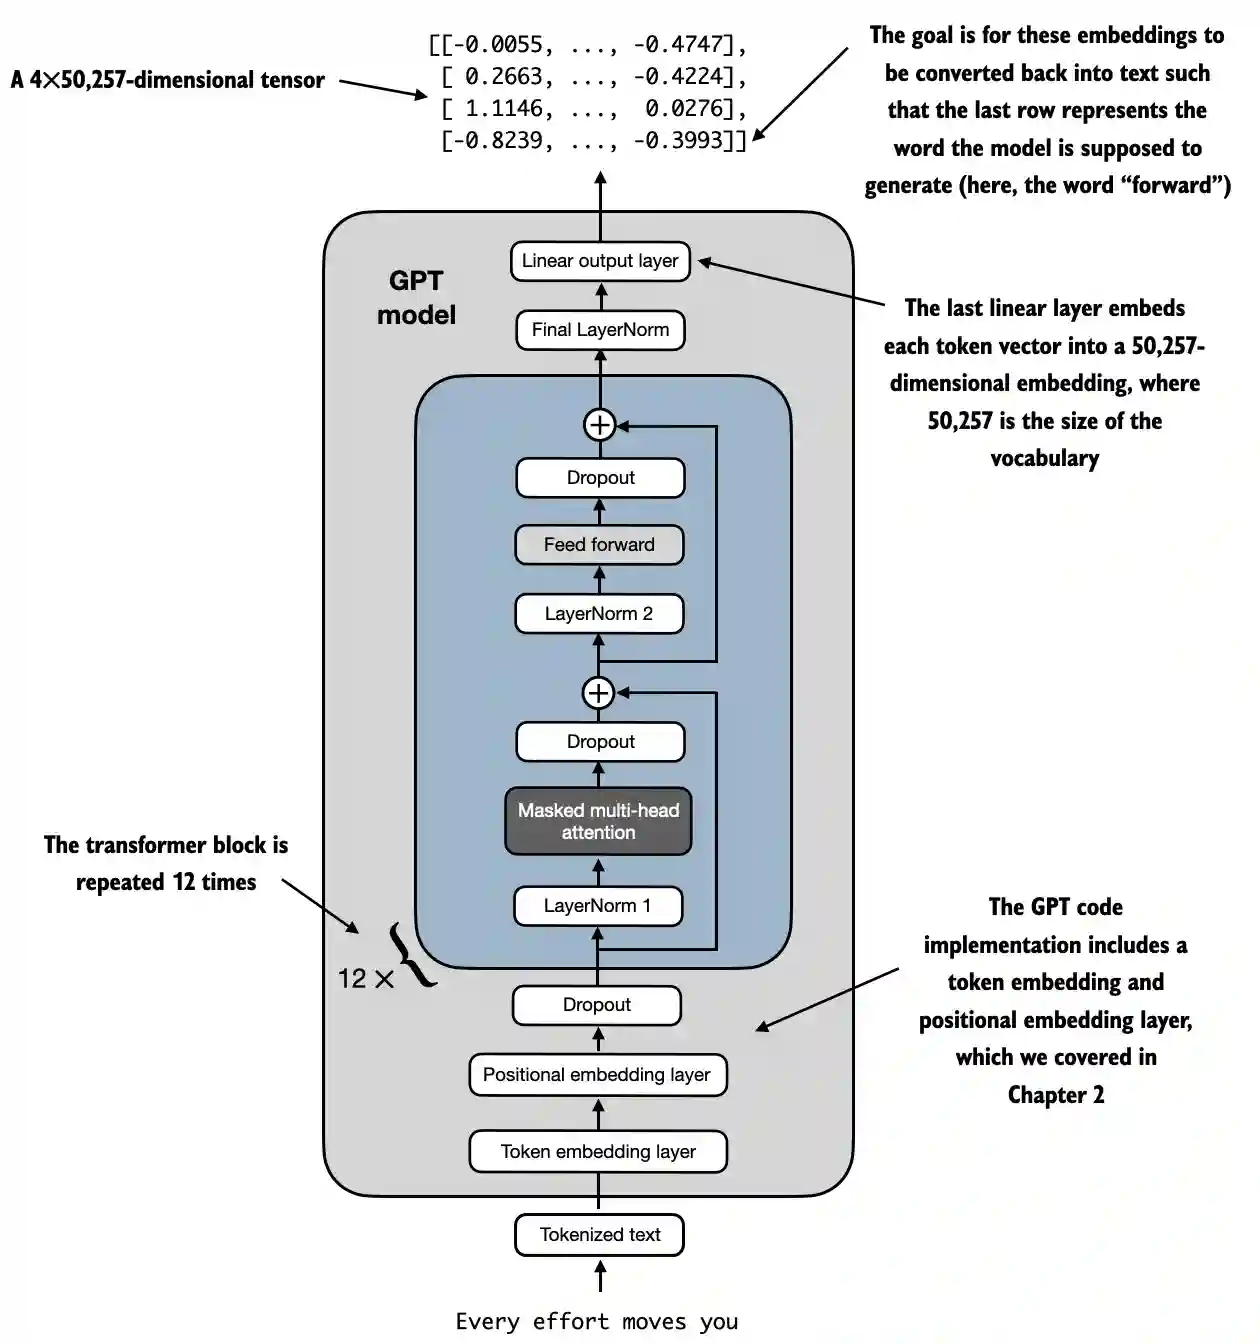

- Input text - Every effort moves you 
- Output text - forward

Amazing explanation by ChatGPT- https://chatgpt.com/share/6710ce12-7050-800b-b824-1589b7995a65

In [86]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])
        # The number of transformer blocks in GPT 2 124M is 12. So we multiply the transf block by n_layers
        self.trf_blocks = nn.Sequential(*[TransformerBlock(cfg) for _ in range(cfg['n_layers'])])
        self.final_norm = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias =False)

    def forward(self, in_idx):
        batch_size , seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device = in_idx.device))
        x = tok_embeds+ pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [87]:
tokenizer = tiktoken.get_encoding("gpt2")
batch = []

txt1 = "where did all the time"
txt2 = "where were you last day"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim = 0)

In [88]:
batch

tensor([[3003,  750,  477,  262,  640],
        [3003,  547,  345,  938, 1110]])

In [89]:
model= GPTModel(GPT_CONFIG_124M)
output = model(batch)

In [90]:
print("Input batch:\n", batch.shape)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 torch.Size([2, 5])

Output shape: torch.Size([2, 3, 768])
tensor([[[ 0.3594,  0.2324,  0.3071,  ...,  0.2616, -0.1215, -0.1016],
         [ 0.2527,  0.2237, -0.1191,  ..., -0.1449, -0.0389, -0.0948],
         [ 0.1321,  0.1485,  0.0199,  ...,  0.2119, -0.2084, -0.0775]],

        [[ 0.0690, -0.1515,  0.0013,  ..., -0.1118, -0.0987, -0.1161],
         [ 0.3083,  0.0374,  0.0125,  ...,  0.1389,  0.4451,  0.1347],
         [ 0.0242, -0.1905, -0.2051,  ...,  0.0019,  0.1495,  0.0438]]],
       grad_fn=<ViewBackward0>)


In [91]:
total_params =  sum(p.numel() for p in model.parameters())
print(total_params)

163009536


In [92]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [93]:
# Weigths tying
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [94]:
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## Generating Text
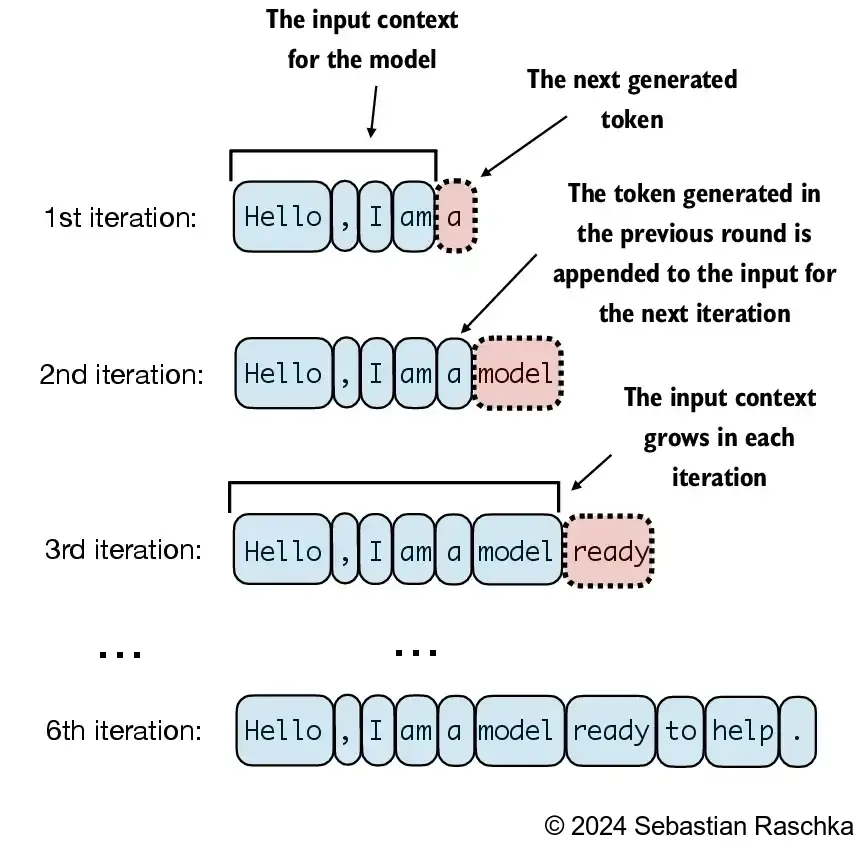
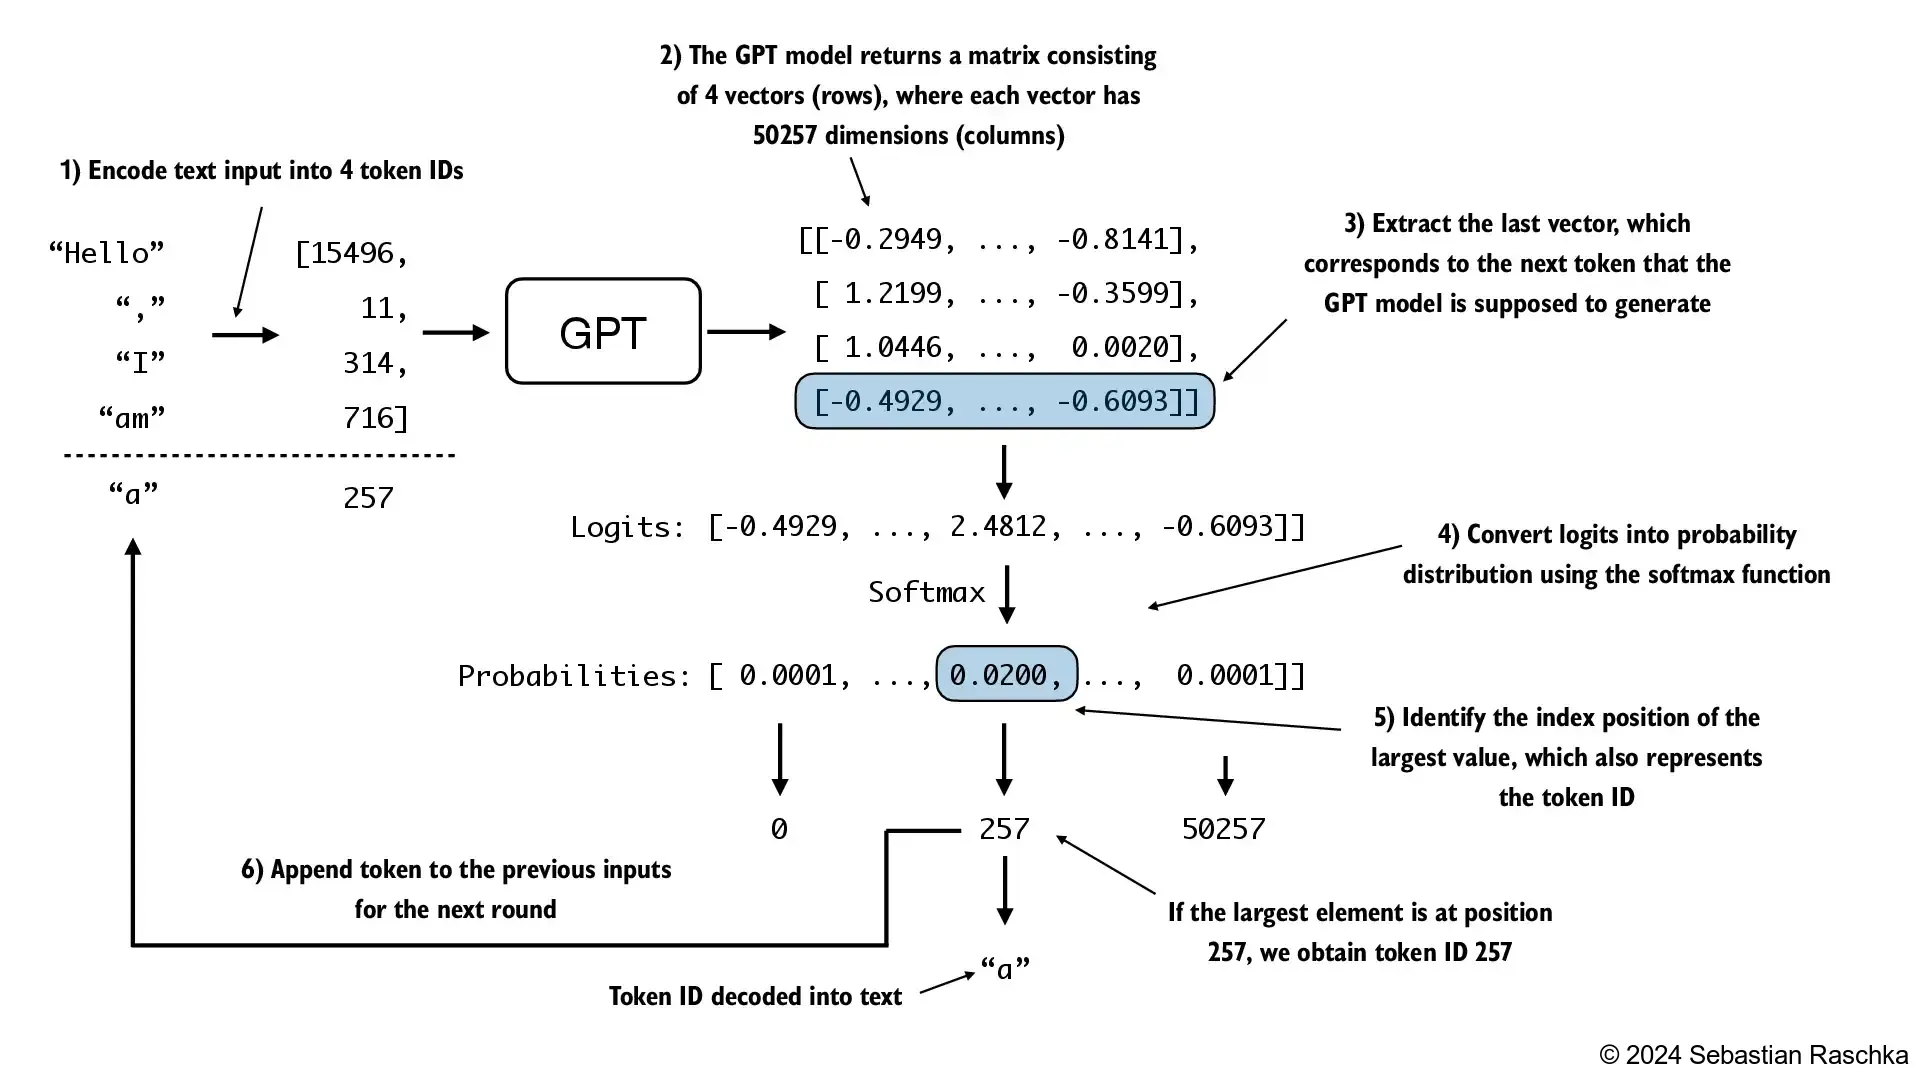

In [95]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # The loop wil create/generate a new token in every iteration.
    for _ in range(max_new_tokens):
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:,-1,:]
        print('Shape of Logits',logits.shape)
        probas = torch.softmax(logits, dim= -1)
        idx_next = torch.argmax(probas, dim=-1, keepdim = True)
        idx = torch.cat((idx, idx_next), dim = 1)
    return idx

In [96]:
start_context = "dhruv is a "

encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [34985, 622, 85, 318, 257, 220]
encoded_tensor.shape: torch.Size([1, 6])


In [99]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=5, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Shape of Logits torch.Size([1, 50257])
Shape of Logits torch.Size([1, 50257])
Shape of Logits torch.Size([1, 50257])
Shape of Logits torch.Size([1, 50257])
Shape of Logits torch.Size([1, 50257])
Output: tensor([[34985,   622,    85,   318,   257,   220, 10014, 27224, 29984,  4121,
          5236]])
Output length: 11


In [100]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

dhruv is a  recall incarceration nucleusyan balance
